# Demo for spheroidal harmonic analysis (SOH) for closed genus-0 surfaces
### This file is part of the paper: [Spheroidal harmonics for generalizing the morphological decomposition of closed parametric surfaces](https://arxiv.org/abs/2407.03350)
### Authors: Mahmoud S. M. Shaqfa and Wim M. van Rees.
### Author of this demo: Mahmoud S. M. Shaqfa (mshaqfa@mit.edu)

In [1]:
# !pip install numpy matplotlib scipy libigl scikit-learn cvxpy h5py mat73 # install libraries (uncomment if needed)

In [2]:
import time, copy, os, sys, scipy, math
import numpy as np
np.set_printoptions(threshold=np.inf)
from mpl_toolkits import mplot3d
from matplotlib import pyplot as plt
import matplotlib.tri as tri
plt.style.use('tableau-colorblind10')
plt.rcParams['text.usetex'] = True
from IPython.display import set_matplotlib_formats
import matplotlib.tri as mtri
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc
from matplotlib import cm, colors
from matplotlib.colors import LightSource
# set_matplotlib_formats('pdf') # For vectorized output of the figures

import igl
# External code helpers
sys.path.append(r'./src')
from polyhedron_spheroid_base import *
from spheroid_coordinates import *
from plot_helper import *
from quads_fit import *
from harmonic_basis import *
from harmonic_helper import * # To call advanced decomposition solvers (Shaqfa et al. 2024a)
from surface_registration import *
from spheroid_parameterization import *
# from spheroid_size_opt import *

## Classify the object as oblate or prolate spheroid

New verts size (18872, 3), and New faces size (37740, 3)
Plot of unregistered configuration:


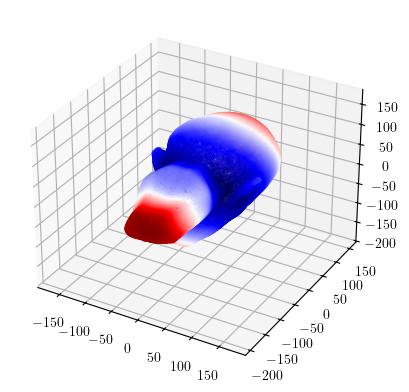

In [3]:
root_folder = os.getcwd()
input_folder = "./input_geometries/" 

stl_name = "max_ref_poisson.stl"
# stl_name = "bumpy_ref.stl"
# stl_name = "bumpy_AR_2.stl"
# stl_name = "Stone.stl"


# Uncomment one of the following four methods to select the analysis approach

# For SH
# parametrization_type = "radial"; force_spherical_harmonics = True; nonlinear_radial_parameterization = False;

# For rSOH
# parametrization_type = "radial"; force_spherical_harmonics = False; nonlinear_radial_parameterization = False;

# For hSOH
# parametrization_type = "radial"; force_spherical_harmonics = False; nonlinear_radial_parameterization = True;

# For c-rSOH
parametrization_type = "cMCF"; force_spherical_harmonics = False; nonlinear_radial_parameterization = False;


# Load and clean meshes
filename = input_folder + stl_name
V, F = igl.read_triangle_mesh(os.path.join(root_folder, filename))
[SV,SVI,SVJ,SF] = igl.remove_duplicate_vertices(V, F, 1e-12);
F = SVJ[F]
V = SV
print("New verts size {}, and New faces size {}".format(V.shape, F.shape))

if parametrization_type == "radial":
    if not force_spherical_harmonics: # Use radial spheroidal harmonics
        # Surface registration step
        centroid, U = register_surface(V, 20000)
        V -= centroid
        v_unrotated = U.T @ V.T
        x_ = v_unrotated[0, :]
        y_ = v_unrotated[1, :]
        z_ = v_unrotated[2, :]
        input_coords = np.array([x_, y_, z_])
        C_sph, spheroid_type = fit_spheroids(input_coords.T, True)
        aspect_ratio = C_sph[0]/C_sph[1]
        print("Stone's aspect ratio a/c = {}".format(aspect_ratio))
if parametrization_type == "cMCF" or force_spherical_harmonics:
    centroid, _ = register_surface(V, 20000)
    V -= centroid
    v_unrotated = V
    if force_spherical_harmonics:
        v_unrotated = v_unrotated.T

r_map = np.sqrt(V[:, 0]**2 + V[:, 1]**2 + V[:, 2]**2)
r_map2 = np.sqrt(v_unrotated[0, :]**2 + v_unrotated[1, :]**2 + v_unrotated[2, :]**2)

print("Plot of unregistered configuration:")
plot_3D_pc(V[:, 0], V[:, 1], V[:, 2], r_map)

# For registering prolate case only
th_y = np.pi/2
R_y = np.array([[np.cos(th_y), 0, np.sin(th_y)],
                [0,            1,            0],
                [-np.sin(th_y), 0, np.cos(th_y)]])

if parametrization_type == "radial":
    # Apply traditional spherical harmonics (optional for comparisons)
    if force_spherical_harmonics:
        spheroid_type = "sphere"
        r_ = 1.0
        C_sph = r_ * np.ones(4)
        print("Spherical harmonics will be used instead with radius = {}".format(r_))
        aspect_ratio = 1
        print("Stone's aspect ratio a/c = {}".format(aspect_ratio))
        x_ = v_unrotated[0, :]
        y_ = v_unrotated[1, :]
        z_ = v_unrotated[2, :]
        V_regs = V
    else:
        # Extra rotations about the y-axis for prolates only
        if spheroid_type == "prolate":
            para_draw_func = plot_parametric_prolate
            v_unrotated = R_y @ v_unrotated
        elif spheroid_type == "oblate":
            para_draw_func = plot_parametric_oblate
        elif spheroid_type == "sphere":
            pass
        x_ = v_unrotated[0, :]
        y_ = v_unrotated[1, :]
        z_ = v_unrotated[2, :]
        print("Plot of registered configuration:")
        V_regs = v_unrotated.T
        if not force_spherical_harmonics:
            plot_3D_pc(x_, y_, z_, r_map2)
            plot_implicit_with_scatter(spheroid_func,
                                       C_sph[0], C_sph[1],
                                       v_unrotated,
                                       bbox=(-r_map2.max(), r_map2.max()))
else:
    V_regs = V

# Surface parametrization

Final Surface area = 185063.37590230608
Optimal spheroid iteration: 3


/home/mahmoud/Desktop/spheroidal-harmonics-published/./src/spheroid_parameterization.py:284: UserWarning: The mapped surface is not star-shaped!
  warnings.warn("The mapped surface is not star-shaped!",


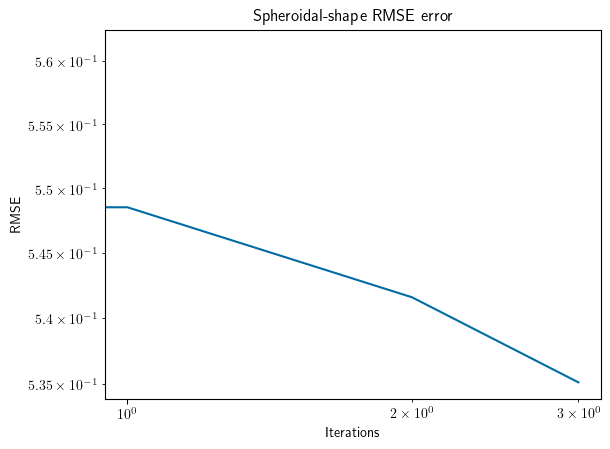

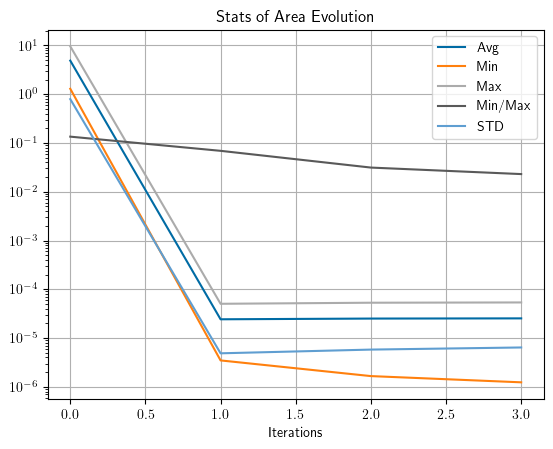

Spheroid parameters of the prolate: a = [99.75516565], c = [177.89468362], f = [147.29367056], zeta = [0.63393243]
Stone's aspect ratio a/c = [0.56075406]


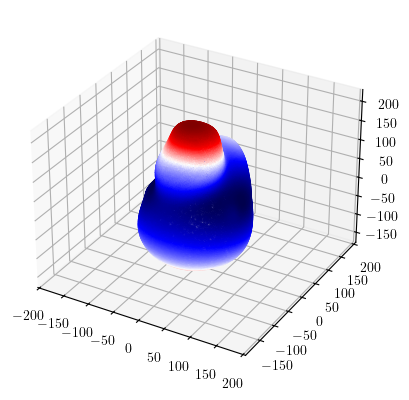

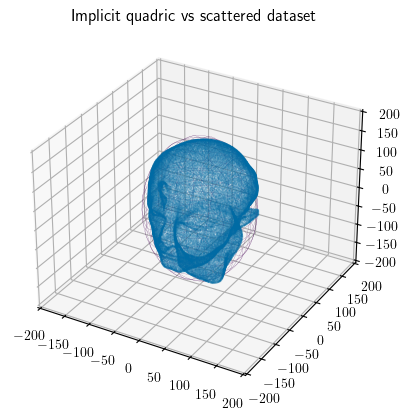

In [4]:
if parametrization_type == "cMCF":
    spheroid_type = "none"
    C_sph = np.ones(4)

if spheroid_type == "prolate":
    cart2spheroid = cart2prolate
    spheroid2catr = prolate2cart
elif spheroid_type == "oblate":
    cart2spheroid = cart2oblate
    spheroid2catr = oblate2cart
elif spheroid_type == "sphere":
    cart2spheroid = cart2sph
    spheroid2catr = sph2cart

# Specific for cMCF mapping
iterations = 4
time_step = 0.0005

# Dump data for cMCF case
filenames_dict = {}
timesteps_folder = "./output/" + stl_name[:-4] + "_para"
timesteps_files = timesteps_folder + "/sim_0000"
group_folder = "./output/"
group_file = group_folder + stl_name[:-4] + "_para"
filenames_dict["timesteps_folder"] = timesteps_folder
filenames_dict["timesteps_files"] = timesteps_files
filenames_dict["group_folder"] = group_folder
filenames_dict["group_file"] = group_file

para_map = parametrization(V_regs, F, spheroid_type, f = C_sph[2], zeta = C_sph[3])

if parametrization_type == "radial":
    V_map, theta_map, phi_map = para_map.compute_radial_para()
    if not force_spherical_harmonics:
        save_name_para = group_folder + "rad_para_" + stl_name
    else:
        save_name_para = group_folder + "sph_rad_para_" + stl_name
    para_map.dump_final_parameterization(save_name_para)
    
elif parametrization_type == "cMCF":
    V_map, theta_map, phi_map = para_map.compute_cMCF_para(iterations, 
                                                           time_step,
                                                           plotresults = True)
    para_map.dump_data_cMCF(filenames_dict,
                            renderstl = False)
    save_name_para = group_folder + "para_" + stl_name
    para_map.dump_final_parameterization(save_name_para)
    
    # Print area evolution data
    plt.figure()
    plt.semilogy(para_map.avg_area_evol, label="Avg")
    plt.semilogy(para_map.min_area_evol, label="Min")
    plt.semilogy(para_map.max_area_evol, label="Max")
    plt.semilogy(para_map.min_area_evol/para_map.max_area_evol,
                 label="Min/Max")
    plt.semilogy(para_map.std_area_evol, label="STD")
    plt.legend()
    plt.grid()
    plt.title("Stats of Area Evolution")
    plt.xlabel("Iterations")
    plt.show()
    
    # Retrieve fit parameteres
    C_sph = para_map.C_sph
    spheroid_type = para_map.spheroid_type
    aspect_ratio = C_sph[0] / C_sph[1]
    print("Spheroid parameters of the {}: a = {}, c = {}, f = {}, zeta = {}".format(
            spheroid_type, C_sph[0], C_sph[1], C_sph[2], C_sph[3]))
    print("Stone's aspect ratio a/c = {}".format(aspect_ratio))
    U = para_map.R_U
    v_unrotated = U.T @ V.T
    if spheroid_type == "prolate":
        v_unrotated = R_y @ v_unrotated

# For nonlinear radial mapping hSOH
if nonlinear_radial_parameterization:
    if parametrization_type == "cMCF":
        V_regs_ = V_map
    else:
        V_regs_ = V_regs
    spheroid_dim = np.array([C_sph[0].item(), C_sph[1].item(), C_sph[2].item()])
    coords_out, multiplier = smart_gradual_spheroid_shrink(V_regs_, spheroid_dim, spheroid_type, theta_c = np.deg2rad(10))
    print("Shrinkage multiplier: ", multiplier)
    C_sph[0] *= multiplier;
    C_sph[1] *= multiplier;
    C_sph[2] *= multiplier;
    plot_implicit_with_scatter(spheroid_func,
                                C_sph[0],
                                C_sph[1],
                                coords_out.T,
                                bbox=(-r_map2.max(), r_map2.max()))
    para_map = parametrization(V_regs, F, spheroid_type, f = C_sph[2], zeta = C_sph[3])
    V_map_f, theta_map, phi_map = para_map.compute_nonlinear_radial_para()
    save_name_para = group_folder + "nonlinear_rad_para_" + stl_name
    para_map.dump_final_parameterization(save_name_para)

rs_ = np.sqrt(V_map[:, 0]**2 + V_map[:, 1]**2 + V_map[:, 2]**2)
plot_3D_pc(V_map[:, 0], V_map[:, 1], V_map[:, 2], rs_)
if not force_spherical_harmonics:
    plot_implicit_with_scatter(spheroid_func, C_sph[0], C_sph[1],
                               v_unrotated,
                               bbox=(-rs_.max(), rs_.max()))

# Decompose harmonics via the least-squares algorithm 


Solver's time: 2.536527701218923 min


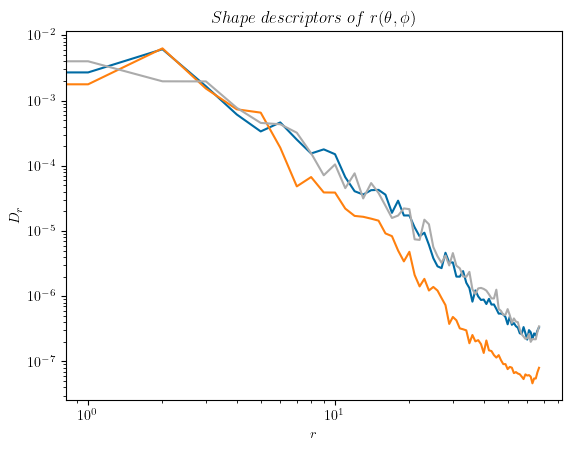

In [5]:
# Basis functions
max_n = 70
rec_max_n = max_n
Y_mat = basis_functions(max_n, theta_map, phi_map, spheroid_type)

# Harmonic solver
harmonic_solver = L2Solvers()
coefs = harmonic_solver.solve_2_norm(Y_mat, V_regs)
coefs_x, coefs_y, coefs_z = coefs[:, 0], coefs[:, 1], coefs[:, 2]

# Shape descriptors
Dr_x, Dr_y, Dr_z = shape_descriptors2(coefs, max_n)

plt.figure()
plt.loglog(np.arange(len(Dr_x)-2), (Dr_x[2::]))
plt.loglog(np.arange(len(Dr_y)-2), (Dr_y[2::]))
plt.loglog(np.arange(len(Dr_z)-2), (Dr_z[2::]))
plt.ylabel(r'$D_r$')
plt.xlabel(r'$r$')
plt.title(r'$Shape~descriptors~of~r(\theta, \phi)$');

# Polyhedron reconstruction

In [6]:
# Creat a polyhedron spheroidal base
theta_sections = 70
phi_sections = 80
f, zeta = C_sph[2], C_sph[3]

if spheroid_type == "prolate":
    cart2spheroid = cart2prolate
    spheroid2catr = prolate2cart
elif spheroid_type == "oblate":
    cart2spheroid = cart2oblate
    spheroid2catr = oblate2cart
elif spheroid_type == "sphere":
    cart2spheroid = cart2sph
    spheroid2catr = sph2cart

reconstruction_base = 2
subdivisions = 5

if reconstruction_base == 1:
    output_pc, ply_V, ply_F = polyhedron_spheroid(f, zeta, spheroid_type, theta_sections,
                                                  phi_sections, refine_poles =  True, plot = False)
elif reconstruction_base == 2:
    ply_V, ply_F = spheroidal_icosahedron(C_sph[0], C_sph[1], subdivisions)
    ply_V = np.array(ply_V); ply_F = np.array(ply_F) 

ply_theta, ply_phi = cart2spheroid(ply_V[:, 0], ply_V[:, 1], ply_V[:, 2], C_sph[2], C_sph[3])
print("Number of reconstruction points: {}".format(ply_V.shape))

Number of reconstruction points: (20472, 3)


# Recursive reconstruction

In [7]:
# dump data
filenames_dict = {}
timesteps_folder = "./output/" + stl_name[:-4] + "_rec"
timesteps_files = timesteps_folder
group_folder = "./output/"
group_file = group_folder + stl_name[:-4] + "_rec"
filenames_dict["timesteps_folder"] = timesteps_folder
filenames_dict["timesteps_files"] = timesteps_files
filenames_dict["group_folder"] = group_folder
filenames_dict["group_file"] = group_file

if parametrization_type == "cMCF":
    save_name = group_folder + "cMCF_rec_" + stl_name
elif parametrization_type == "radial":
    if not force_spherical_harmonics:
        save_name = group_folder + "radial_rec_" + stl_name
    else:
        save_name = group_folder + "sph_radial_rec_" + stl_name
    if nonlinear_radial_parameterization:
        save_name = group_folder + "nonlinear_radial_rec_" + stl_name

ply_rec_verts_unregst = recursive_basis_reconstruction(coefs_x, coefs_y, coefs_z,
                                                       ply_theta, ply_phi, ply_F,
                                                       rec_max_n, spheroid_type,
                                                       filenames_dict, increment = 5,
                                                       renderstl = False)
ply_rec_verts = copy.copy(ply_rec_verts_unregst)

# 1 - Rotations
if parametrization_type == "radial":
    if spheroid_type == "prolate":
        th__y = np.pi/2
        R__y = np.array([[np.cos(th__y), 0, np.sin(th__y)],
                        [0,            1,            0],
                        [-np.sin(th__y), 0, np.cos(th__y)]])
        ply_rec_verts = ply_rec_verts @ R__y @ U.T
    if spheroid_type == "oblate":# or spheroid_type == "sphere":
        ply_rec_verts = ply_rec_verts @ U.T

# 2- Translation
ply_rec_verts += centroid

igl.write_triangle_mesh(save_name,
                        ply_rec_verts, ply_F)

True

# Export Gnuplot data

In [8]:
if parametrization_type == "cMCF":
    save_name_gnu = "cMCF_rec_" + stl_name
elif parametrization_type == "radial":
    if not force_spherical_harmonics:
        save_name_gnu = "radial_rec_" + stl_name
    else:
        save_name_gnu = "sph_radial_rec_" + stl_name
    if nonlinear_radial_parameterization:
        save_name_gnu = "nonlinear_radial_rec_" + stl_name
        
render_surfaces_gnuplot(fname=save_name_gnu,
                        directory=group_folder,
                        V = ply_rec_verts, F = ply_F,
                        extra_field = [])
render_surfaces_gnuplot(fname=stl_name,
                        directory=group_folder,
                        V = V, F = F,
                        extra_field = [])